## Import stuff

In [3]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## define directory and loop through all folders

In [4]:
# Replace with the path to your dataset
base_dir = '/users/Navneet/downloads/bootstrap_samples' 

In [5]:
# Define a function to split data and create train, validation, test directories
def create_data_splits(base_path):
    species_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    train_dir = os.path.join(base_path, 'train')
    val_dir = os.path.join(base_path, 'val')
    test_dir = os.path.join(base_path, 'test')

    for dir in [train_dir, val_dir, test_dir]:
        os.makedirs(dir, exist_ok=True)

    for species in species_folders:
        species_path = os.path.join(base_path, species)
        train_species_path = os.path.join(train_dir, species)
        val_species_path = os.path.join(val_dir, species)
        test_species_path = os.path.join(test_dir, species)

        for path in [train_species_path, val_species_path, test_species_path]:
            os.makedirs(path, exist_ok=True)

        images = [f for f in os.listdir(species_path) if os.path.isfile(os.path.join(species_path, f))]
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

        for image in train_images:
            shutil.copy(os.path.join(species_path, image), os.path.join(train_species_path, image))
        for image in val_images:
            shutil.copy(os.path.join(species_path, image), os.path.join(val_species_path, image))
        for image in test_images:
            shutil.copy(os.path.join(species_path, image), os.path.join(test_species_path, image))

# Run the function to create the splits
create_data_splits(base_dir)

# Assuming you have more than 2 classes, let's say 'n_classes' is the number of classes
n_classes = len(next(os.walk(os.path.join(base_dir, 'train')))[1])  # Number of species directories

## model 

In [6]:
# Build the model
model = Sequential([
    Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(),
    Dense(units=4096, activation="relu"),
    Dense(units=4096, activation="relu"),
    Dense(units=n_classes, activation="softmax")
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## train data

In [7]:
# Create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10  # You can change the number of epochs
)

# Save the trained model
model.save(os.path.join(base_dir, 'model.h5'))

# Load the trained model
model = tf.keras.models.load_model(os.path.join(base_dir, 'model.h5'))

Found 718 images belonging to 12 classes.
Found 240 images belonging to 12 classes.
Epoch 1/10
22/22 [==============================] - 71s 3s/step - loss: 4.6399 - accuracy: 0.0714 - val_loss: 2.4839 - val_accuracy: 0.0893
Epoch 2/10
22/22 [==============================] - 68s 3s/step - loss: 2.4394 - accuracy: 0.1195 - val_loss: 2.4137 - val_accuracy: 0.1786
Epoch 3/10
22/22 [==============================] - 70s 3s/step - loss: 2.5062 - accuracy: 0.0860 - val_loss: 2.4828 - val_accuracy: 0.0759
Epoch 4/10
22/22 [==============================] - 70s 3s/step - loss: 2.4586 - accuracy: 0.1278 - val_loss: 2.3431 - val_accuracy: 0.0982
Epoch 5/10
22/22 [==============================] - 68s 3s/step - loss: 2.0568 - accuracy: 0.2289 - val_loss: 1.7416 - val_accuracy: 0.3750
Epoch 6/10
22/22 [==============================] - 69s 3s/step - loss: 1.5493 - accuracy: 0.5175 - val_loss: 1.5014 - val_accuracy: 0.5045
Epoch 7/10
22/22 [==============================] - 70s 3s/step - loss: 0.59

/Users/navneet/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## test data

In [8]:
# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=1,  # Batch size for testing can be set to 1 for one image at a time
    class_mode='categorical',
    shuffle=False  # No need to shuffle the test data
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 242 images belonging to 12 classes.
242/242 [==============================] - 19s 76ms/step - loss: 0.0573 - accuracy: 0.9959
Test Accuracy: 99.59%


## input output? 

1/1 [==============================] - 0s 309ms/step
The image is predicted to be a 'Bombus-Californicus-Isolated' with a confidence of 1.00


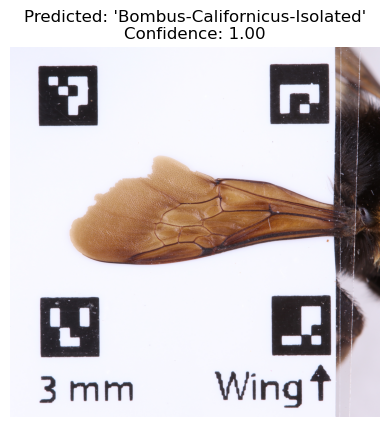

In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Rescale as we did with the ImageDataGenerator
    return img

# Function to predict the species from an image
def predict_species(model, class_indices, image_path):
    img = load_and_preprocess_image(image_path)
    pred = model.predict(img)
    predicted_class = np.argmax(pred, axis=1)
    predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class[0])]
    confidence = np.max(pred)
    return predicted_class_name, confidence

def display_prediction(image_path, predicted_species, confidence):
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: '{predicted_species}'\nConfidence: {confidence:.2f}")
    plt.axis('off')  # Hide the axes
    plt.show()


# Load the trained model
model_path = os.path.join(base_dir, 'model.h5')
model = load_model(model_path)

# Get the class indices from the training data generator
class_indices = train_generator.class_indices

# Replace this with the path to the image you want to classify
input_image_path = '/users/Navneet/downloads/UCSB-IZC00010425_R.JPG'

# Predict the species from the input image
predicted_species, confidence = predict_species(model, class_indices, input_image_path)

# Print out the result
print(f"The image is predicted to be a '{predicted_species}' with a confidence of {confidence:.2f}")

display_prediction(input_image_path, predicted_species, confidence)
